# Dark Matter Index Analysis: Exploring Hash Diversity Patterns

## Hypothesis

The multi-modal distribution of alpha diversity vs hash density observed across metagenome samples may be explained by the **Dark Matter Index (DMI)** — the fraction of k-mer hashes in a sample that do not map to any reference database.

Specifically, we hypothesize that:
1. Samples with high hash density but low alpha diversity (the "outlier" clusters) have high DMI values
2. These samples contain substantial uncharacterized genetic material ("dark matter") that inflates hash counts without contributing to mapped species diversity
3. DMI varies systematically by organism type, with some environments (e.g., soil) harboring more unmapped diversity

## Analysis Overview

1. **Data Overview**: Load and explore the merged dataset
2. **DMI Distribution**: Understand the overall distribution of dark matter across samples
3. **DMI vs Hash Metrics Correlation**: Quantify relationships between DMI and hash density/diversity
4. **Organism-Stratified Analysis**: Reproduce hash-diversity plots with DMI coloring
5. **Top/Bottom Organisms**: Deep dive into organisms with highest/lowest DMI
6. **Outlier Investigation**: Directly test if circled outliers have elevated DMI
7. **Statistical Testing**: Formal hypothesis tests

In [4]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, kendalltau
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# For non-interactive backend (headless mode)
import matplotlib
# Uncomment the following line for headless execution:
# matplotlib.use('Agg')

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading and Overview

In [48]:
# ============================================================
# CONFIGURE THIS PATH TO YOUR MERGED PARQUET FILE
# ============================================================
PARQUET_PATH = "/scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_mbases_1620_min_diversity_10/filtered_data_with_dmi_merged.parquet"
#PARQUET_PATH = "/scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_hash_10000_min_diversity_10/filtered_data_with_dmi_merged.parquet"

# Load data
print(f"Loading data from: {PARQUET_PATH}")
df = pd.read_parquet(PARQUET_PATH)
print(f"\nDataset shape: {df.shape[0]:,} samples × {df.shape[1]} columns")

Loading data from: /scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_mbases_1620_min_diversity_10/filtered_data_with_dmi_merged.parquet

Dataset shape: 201,059 samples × 29 columns


In [49]:
# Display column information
print("Columns in dataset:")
print("-" * 50)
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    print(f"{i+1:2}. {col:30} {str(dtype):15} ({non_null:,} non-null)")

Columns in dataset:
--------------------------------------------------
 1. accession                      object          (201,059 non-null)
 2. hashes_per_mb                  float64         (201,059 non-null)
 3. total_distinct_hashes          int64           (201,059 non-null)
 4. diversity_per_mb               float64         (201,059 non-null)
 5. alpha_diversity                int64           (201,059 non-null)
 6. mbases_x                       int32           (201,059 non-null)
 7. biosample                      object          (201,059 non-null)
 8. organism                       object          (201,059 non-null)
 9. instrument                     object          (201,059 non-null)
10. platform                       object          (201,059 non-null)
11. sra_study                      object          (200,980 non-null)
12. bioproject                     object          (200,959 non-null)
13. center_name                    object          (201,059 non-null)
14. librarylayout  

In [50]:
# Key columns for analysis
key_columns = ['accession', 'hashes_per_mb', 'total_distinct_hashes', 'diversity_per_mb', 
               'alpha_diversity', 'mbases_x', 'dmi', 'total_hashes_dmi', 'unmapped_hashes',
               'mapped_hashes', 'organism']

# Check which key columns exist
available_keys = [c for c in key_columns if c in df.columns]
missing_keys = [c for c in key_columns if c not in df.columns]

if missing_keys:
    print(f"Warning: Missing expected columns: {missing_keys}")

# Display summary statistics for numeric columns
numeric_cols = ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'dmi', 
                'total_distinct_hashes', 'unmapped_hashes', 'mapped_hashes']
numeric_cols = [c for c in numeric_cols if c in df.columns]

print("\nSummary Statistics for Key Numeric Columns:")
print("=" * 80)
df[numeric_cols].describe().round(4)


Summary Statistics for Key Numeric Columns:


hashes_per_mb  diversity_per_mb  alpha_diversity          dmi  \
count    201059.0000       201059.0000      201059.0000  201059.0000   
mean         65.5681            0.4698        3132.4743       0.2819   
std          44.1788            0.3884        3418.0063       0.2637   
min           0.2264            0.0011          10.0000       0.0003   
25%          31.2929            0.1875        1045.0000       0.0616   
50%          55.4139            0.3820        2201.0000       0.1718   
75%          91.6957            0.6431        3656.0000       0.4721   
max         359.0997            4.1175       40039.0000       0.9974   

       total_distinct_hashes  unmapped_hashes  mapped_hashes  
count           2.010590e+05     2.010590e+05   2.010590e+05  
mean            5.488771e+05     2.436359e+05   3.052411e+05  
std             8.362592e+05     6.483223e+05   3.187660e+05  
min             1.787000e+03     2.400000e+01   9.100000e+01  
25%             1.564775e+05     1.367800e+04   1.111140e+05  
50%             2.965670e+05     3.271500e+04   2.227340e+05  
75%             5.622505e+05     1.577865e+05   3.822840e+05  
max             3.210690e+07     2.640130e+07   7.308805e+06

In [51]:
# Check DMI coverage
n_total = len(df)
n_with_dmi = df['dmi'].notna().sum()
n_without_dmi = n_total - n_with_dmi

print(f"DMI Coverage:")
print(f"  Total samples: {n_total:,}")
print(f"  With DMI: {n_with_dmi:,} ({100*n_with_dmi/n_total:.2f}%)")
print(f"  Without DMI: {n_without_dmi:,} ({100*n_without_dmi/n_total:.2f}%)")

# Filter to samples with DMI for subsequent analysis
df_dmi = df[df['dmi'].notna()].copy()
print(f"\nUsing {len(df_dmi):,} samples with DMI values for analysis")

DMI Coverage:
  Total samples: 201,059
  With DMI: 201,059 (100.00%)
  Without DMI: 0 (0.00%)

Using 201,059 samples with DMI values for analysis


## 2. DMI Distribution Analysis

Understanding the overall distribution of Dark Matter Index values across all samples.

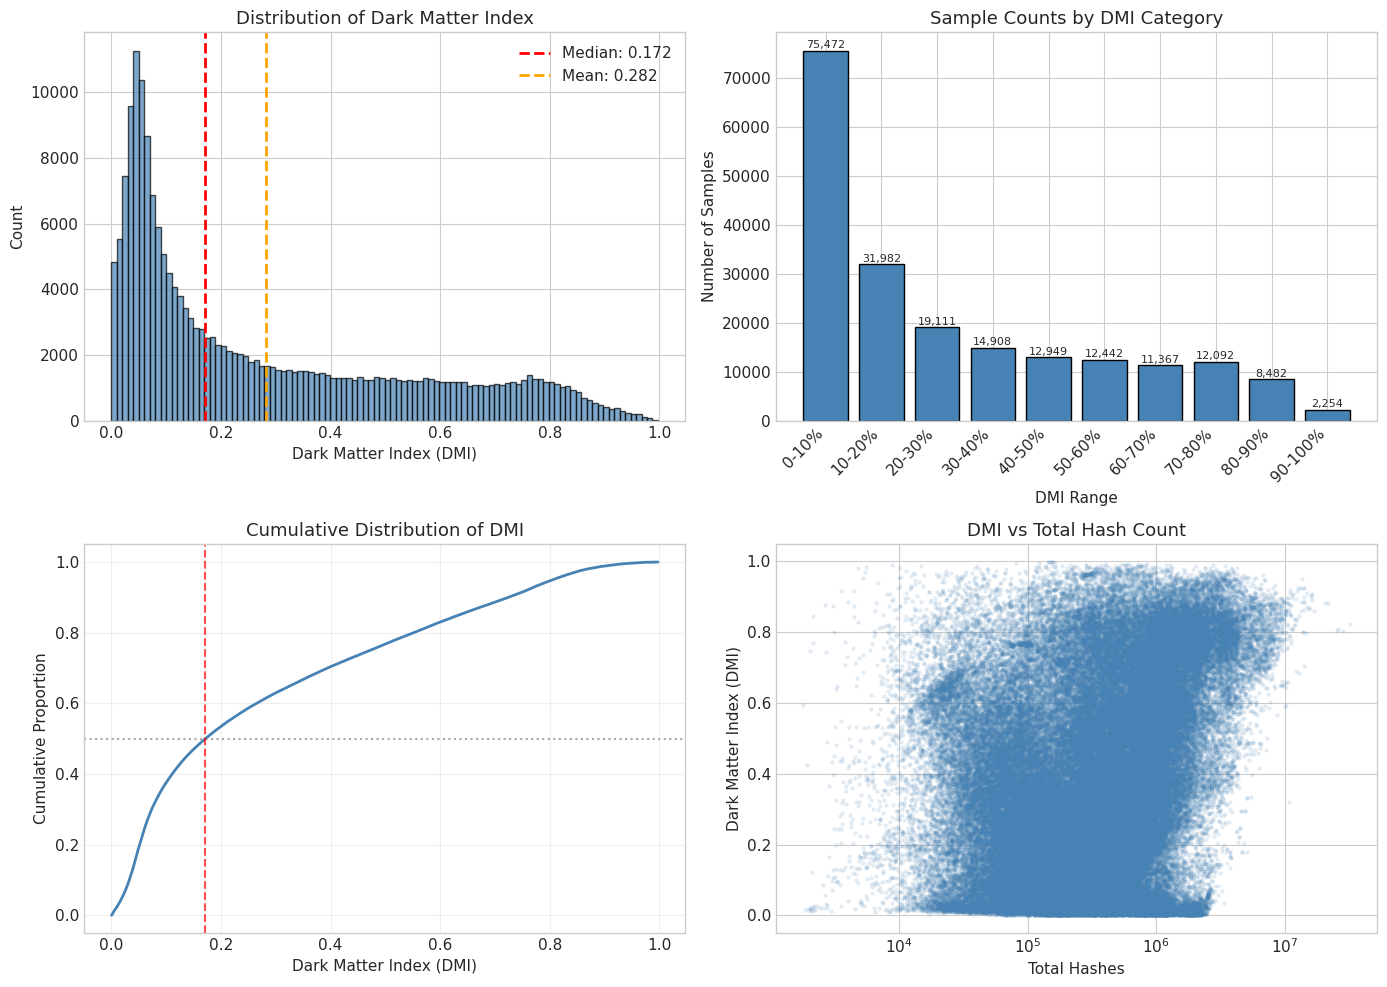


Figure saved: dmi_distribution_overview.png

Correlation between DMI and Total Hashes:
  Spearman ρ = 0.2184 (p = 0.00e+00)
  Kendall τ  = 0.1437 (p = 0.00e+00)


In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 2a. Histogram of DMI
ax = axes[0, 0]
ax.hist(df_dmi['dmi'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df_dmi['dmi'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_dmi["dmi"].median():.3f}')
ax.axvline(df_dmi['dmi'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df_dmi["dmi"].mean():.3f}')
ax.set_xlabel('Dark Matter Index (DMI)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Dark Matter Index')
ax.legend()

# 2b. Box plot by DMI category
ax = axes[0, 1]
df_dmi['dmi_category'] = pd.cut(df_dmi['dmi'], 
                                 bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                 labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
                                        '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
category_counts = df_dmi['dmi_category'].value_counts().sort_index()
bars = ax.bar(range(len(category_counts)), category_counts.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right')
ax.set_xlabel('DMI Range')
ax.set_ylabel('Number of Samples')
ax.set_title('Sample Counts by DMI Category')

# Add count labels on bars
for bar, count in zip(bars, category_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}', ha='center', va='bottom', fontsize=8)

# 2c. Cumulative distribution
ax = axes[1, 0]
sorted_dmi = np.sort(df_dmi['dmi'])
cumulative = np.arange(1, len(sorted_dmi) + 1) / len(sorted_dmi)
ax.plot(sorted_dmi, cumulative, linewidth=2, color='steelblue')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.7)
ax.axvline(df_dmi['dmi'].median(), color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Dark Matter Index (DMI)')
ax.set_ylabel('Cumulative Proportion')
ax.set_title('Cumulative Distribution of DMI')
ax.grid(True, alpha=0.3)

# 2d. DMI vs total hashes (sanity check)
ax = axes[1, 1]
ax.scatter(df_dmi['total_hashes_dmi'], df_dmi['dmi'], alpha=0.1, s=5, color='steelblue')
ax.set_xlabel('Total Hashes')
ax.set_ylabel('Dark Matter Index (DMI)')
ax.set_title('DMI vs Total Hash Count')
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('dmi_distribution_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: dmi_distribution_overview.png")
r_spearman, p_spearman = spearmanr(df_dmi['dmi'], df_dmi['total_hashes_dmi'])
tau, p_tau = kendalltau(df_dmi['dmi'], df_dmi['total_hashes_dmi'])
print(f"\nCorrelation between DMI and Total Hashes:")
print(f"  Spearman ρ = {r_spearman:.4f} (p = {p_spearman:.2e})")
print(f"  Kendall τ  = {tau:.4f} (p = {p_tau:.2e})")

### Interpretation Guide

**Top-left (Histogram)**: Shows the overall shape of DMI distribution. 
- If bimodal: suggests two distinct populations (well-characterized vs dark matter-rich)
- If right-skewed: most samples are well-characterized, few have high dark matter
- If left-skewed: most samples have substantial unmapped content

**Top-right (Category counts)**: Quick view of how many samples fall into each DMI bin.

**Bottom-left (CDF)**: Useful for statements like "X% of samples have DMI < Y"

**Bottom-right (DMI vs total hashes)**: Sanity check that DMI doesn't trivially correlate with sample size.

## 3. DMI vs Hash Metrics Correlation

Core analysis: Does DMI explain the relationship between hash density and diversity?

In [53]:
# Calculate correlation matrix for key variables
correlation_vars = ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'dmi', 
                    'unmapped_hashes', 'mapped_hashes', 'total_distinct_hashes']
correlation_vars = [c for c in correlation_vars if c in df_dmi.columns]

# Pearson correlation
print("Pearson Correlation Matrix:")
print("=" * 80)
corr_matrix = df_dmi[correlation_vars].corr(method='pearson')
display(corr_matrix.round(3))

Pearson Correlation Matrix:


hashes_per_mb  diversity_per_mb  alpha_diversity  \
hashes_per_mb                  1.000             0.595            0.508   
diversity_per_mb               0.595             1.000            0.428   
alpha_diversity                0.508             0.428            1.000   
dmi                            0.237             0.109            0.427   
unmapped_hashes                0.388             0.102            0.767   
mapped_hashes                  0.444            -0.012            0.522   
total_distinct_hashes          0.470             0.075            0.794   

                         dmi  unmapped_hashes  mapped_hashes  \
hashes_per_mb          0.237            0.388          0.444   
diversity_per_mb       0.109            0.102         -0.012   
alpha_diversity        0.427            0.767          0.522   
dmi                    1.000            0.539         -0.038   
unmapped_hashes        0.539            1.000          0.429   
mapped_hashes         -0.038            0.429          1.000   
total_distinct_hashes  0.403            0.939          0.714   

                       total_distinct_hashes  
hashes_per_mb                          0.470  
diversity_per_mb                       0.075  
alpha_diversity                        0.794  
dmi                                    0.403  
unmapped_hashes                        0.939  
mapped_hashes                          0.714  
total_distinct_hashes                  1.000

In [54]:
# Spearman correlation (more robust to outliers)
print("\nSpearman Correlation Matrix:")
print("=" * 80)
corr_matrix_spearman = df_dmi[correlation_vars].corr(method='spearman')
display(corr_matrix_spearman.round(3))


Spearman Correlation Matrix:


hashes_per_mb  diversity_per_mb  alpha_diversity  \
hashes_per_mb                  1.000             0.647            0.517   
diversity_per_mb               0.647             1.000            0.651   
alpha_diversity                0.517             0.651            1.000   
dmi                            0.049             0.003            0.230   
unmapped_hashes                0.362             0.169            0.601   
mapped_hashes                  0.555             0.207            0.657   
total_distinct_hashes          0.654             0.251            0.744   

                         dmi  unmapped_hashes  mapped_hashes  \
hashes_per_mb          0.049            0.362          0.555   
diversity_per_mb       0.003            0.169          0.207   
alpha_diversity        0.230            0.601          0.657   
dmi                    1.000            0.805         -0.155   
unmapped_hashes        0.805            1.000          0.388   
mapped_hashes         -0.155            0.388          1.000   
total_distinct_hashes  0.218            0.690          0.879   

                       total_distinct_hashes  
hashes_per_mb                          0.654  
diversity_per_mb                       0.251  
alpha_diversity                        0.744  
dmi                                    0.218  
unmapped_hashes                        0.690  
mapped_hashes                          0.879  
total_distinct_hashes                  1.000

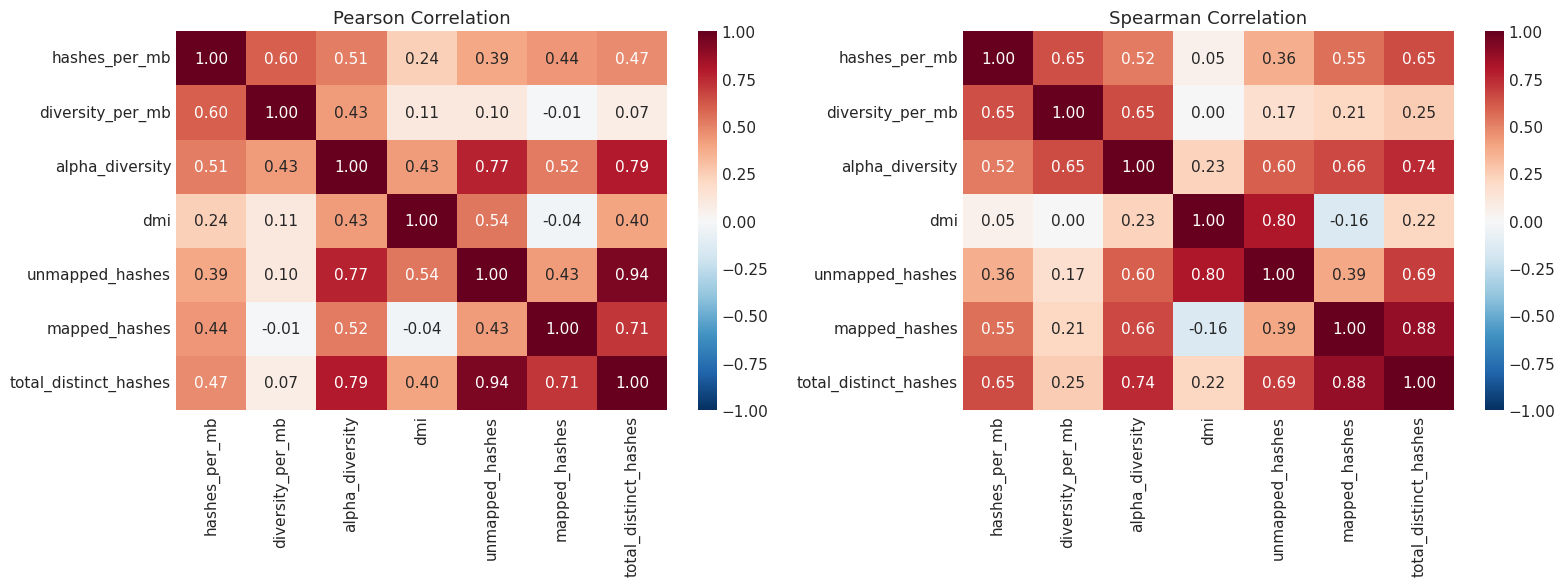

Figure saved: correlation_matrices.png


In [55]:
# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], fmt='.2f')
axes[0].set_title('Pearson Correlation')

# Spearman
sns.heatmap(corr_matrix_spearman, annot=True, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], fmt='.2f')
axes[1].set_title('Spearman Correlation')

plt.tight_layout()
plt.savefig('correlation_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: correlation_matrices.png")

In [56]:
# Key correlation: DMI vs hashes_per_mb and diversity_per_mb
print("\nKey Correlations with DMI:")
print("=" * 60)

for var in ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'unmapped_hashes']:
    if var in df_dmi.columns:
        r_pearson, p_pearson = pearsonr(df_dmi['dmi'], df_dmi[var])
        r_spearman, p_spearman = spearmanr(df_dmi['dmi'], df_dmi[var])
        tau, p_tau = kendalltau(df_dmi['dmi'], df_dmi[var])
        
        print(f"\nDMI vs {var}:")
        print(f"  Pearson r  = {r_pearson:.4f} (p = {p_pearson:.2e})")
        print(f"  Spearman ρ = {r_spearman:.4f} (p = {p_spearman:.2e})")
        print(f"  Kendall τ  = {tau:.4f} (p = {p_tau:.2e})")


Key Correlations with DMI:

DMI vs hashes_per_mb:
  Pearson r  = 0.2370 (p = 0.00e+00)
  Spearman ρ = 0.0485 (p = 4.31e-105)
  Kendall τ  = 0.0105 (p = 1.70e-12)

DMI vs diversity_per_mb:
  Pearson r  = 0.1091 (p = 0.00e+00)
  Spearman ρ = 0.0026 (p = 2.37e-01)
  Kendall τ  = -0.0135 (p = 1.01e-19)

DMI vs alpha_diversity:
  Pearson r  = 0.4270 (p = 0.00e+00)
  Spearman ρ = 0.2296 (p = 0.00e+00)
  Kendall τ  = 0.1575 (p = 0.00e+00)

DMI vs unmapped_hashes:
  Pearson r  = 0.5386 (p = 0.00e+00)
  Spearman ρ = 0.8050 (p = 0.00e+00)
  Kendall τ  = 0.6228 (p = 0.00e+00)


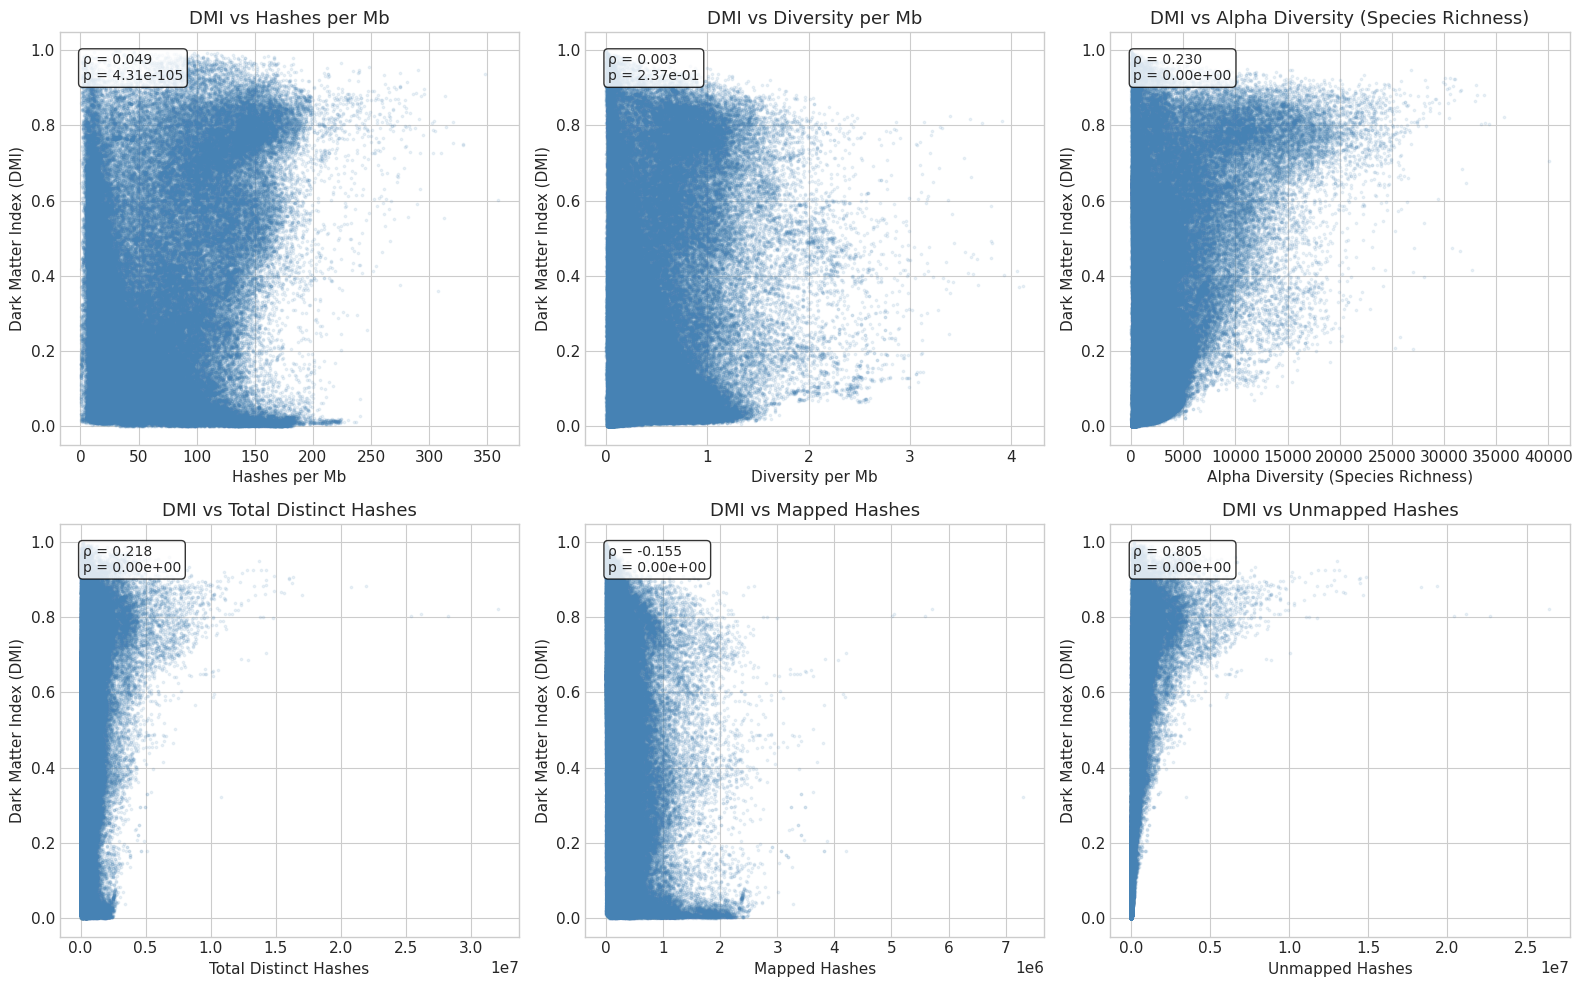

Figure saved: dmi_vs_metrics_scatter.png


In [57]:
# Scatter plots: DMI vs key metrics
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_configs = [
    ('hashes_per_mb', 'Hashes per Mb'),
    ('diversity_per_mb', 'Diversity per Mb'),
    ('alpha_diversity', 'Alpha Diversity (Species Richness)'),
    ('total_distinct_hashes', 'Total Distinct Hashes'),
    ('mapped_hashes', 'Mapped Hashes'),
    ('unmapped_hashes', 'Unmapped Hashes')
]

for idx, (var, title) in enumerate(plot_configs):
    if var not in df_dmi.columns:
        continue
    ax = axes[idx // 3, idx % 3]
    
    ax.scatter(df_dmi[var], df_dmi['dmi'], alpha=0.1, s=3, color='steelblue')
    
    # Add correlation info
    r, p = spearmanr(df_dmi[var], df_dmi['dmi'])
    ax.text(0.05, 0.95, f'ρ = {r:.3f}\np = {p:.2e}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(title)
    ax.set_ylabel('Dark Matter Index (DMI)')
    ax.set_title(f'DMI vs {title}')

plt.tight_layout()
plt.savefig('dmi_vs_metrics_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: dmi_vs_metrics_scatter.png")

### Interpretation Guide

**Key relationships to look for:**

1. **DMI vs Hashes per Mb**: 
   - Positive correlation suggests samples with more hashes have more dark matter
   - Could indicate that high-hash samples are sampling deeper into unexplored sequence space

2. **DMI vs Diversity per Mb**:
   - Negative correlation would support hypothesis: high DMI → low diversity ratio
   - Positive would be surprising and require reinterpretation

3. **DMI vs Alpha Diversity**:
   - Should be weakly negative or uncorrelated if DMI represents truly unmapped content
   - Strong negative correlation would strongly support the hypothesis

## 4. Hash-Diversity Plots with DMI Coloring

Recreating the original organism-stratified scatter plots, but now colored by DMI to visualize whether the "outlier" clusters have elevated dark matter content.

In [58]:
# Get top organisms by sample count
if 'organism' in df_dmi.columns:
    organism_counts = df_dmi['organism'].value_counts()
    print("Top 20 organisms by sample count:")
    print("=" * 50)
    for i, (org, count) in enumerate(organism_counts.head(20).items()):
        median_dmi = df_dmi[df_dmi['organism'] == org]['dmi'].median()
        print(f"{i+1:2}. {org:40} n={count:6,}  median DMI={median_dmi:.3f}")

Top 20 organisms by sample count:
 1. human gut metagenome                     n=61,440  median DMI=0.073
 2. metagenome                               n=18,595  median DMI=0.197
 3. gut metagenome                           n=15,161  median DMI=0.101
 4. soil metagenome                          n= 8,765  median DMI=0.763
 5. human metagenome                         n= 6,803  median DMI=0.061
 6. feces metagenome                         n= 6,563  median DMI=0.115
 7. marine metagenome                        n= 6,400  median DMI=0.536
 8. mouse gut metagenome                     n= 5,258  median DMI=0.065
 9. Homo sapiens                             n= 5,140  median DMI=0.096
10. human feces metagenome                   n= 4,653  median DMI=0.231
11. unidentified                             n= 3,763  median DMI=0.221
12. wastewater metagenome                    n= 2,888  median DMI=0.312
13. pig gut metagenome                       n= 2,739  median DMI=0.214
14. sediment metagenome       

In [59]:
def plot_organism_hash_diversity_dmi(df, organism, ax):
    """
    Plot hash density vs diversity for a single organism, colored by DMI.
    """
    subset = df[df['organism'] == organism].copy()
    
    if len(subset) == 0:
        ax.text(0.5, 0.5, f'No data for {organism}', ha='center', va='center', transform=ax.transAxes)
        return
    
    # Create scatter plot colored by DMI
    scatter = ax.scatter(subset['hashes_per_mb'], subset['diversity_per_mb'], 
                        c=subset['dmi'], cmap='RdYlBu_r', 
                        alpha=0.6, s=10, vmin=0, vmax=1)
    
    # Add regression line
    x = subset['hashes_per_mb'].values
    y = subset['diversity_per_mb'].values
    
    # Remove NaN values for regression
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    if len(x_clean) > 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8)
        
        # Calculate additional correlations
        r_spearman, _ = spearmanr(x_clean, y_clean)
        
        # Add stats text
        stats_text = f'n={len(subset):,}\nr={r_value:.3f}\nρ={r_spearman:.3f}\nR²={r_value**2:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    ax.set_title(organism)
    
    return scatter

Plotting 12 organisms


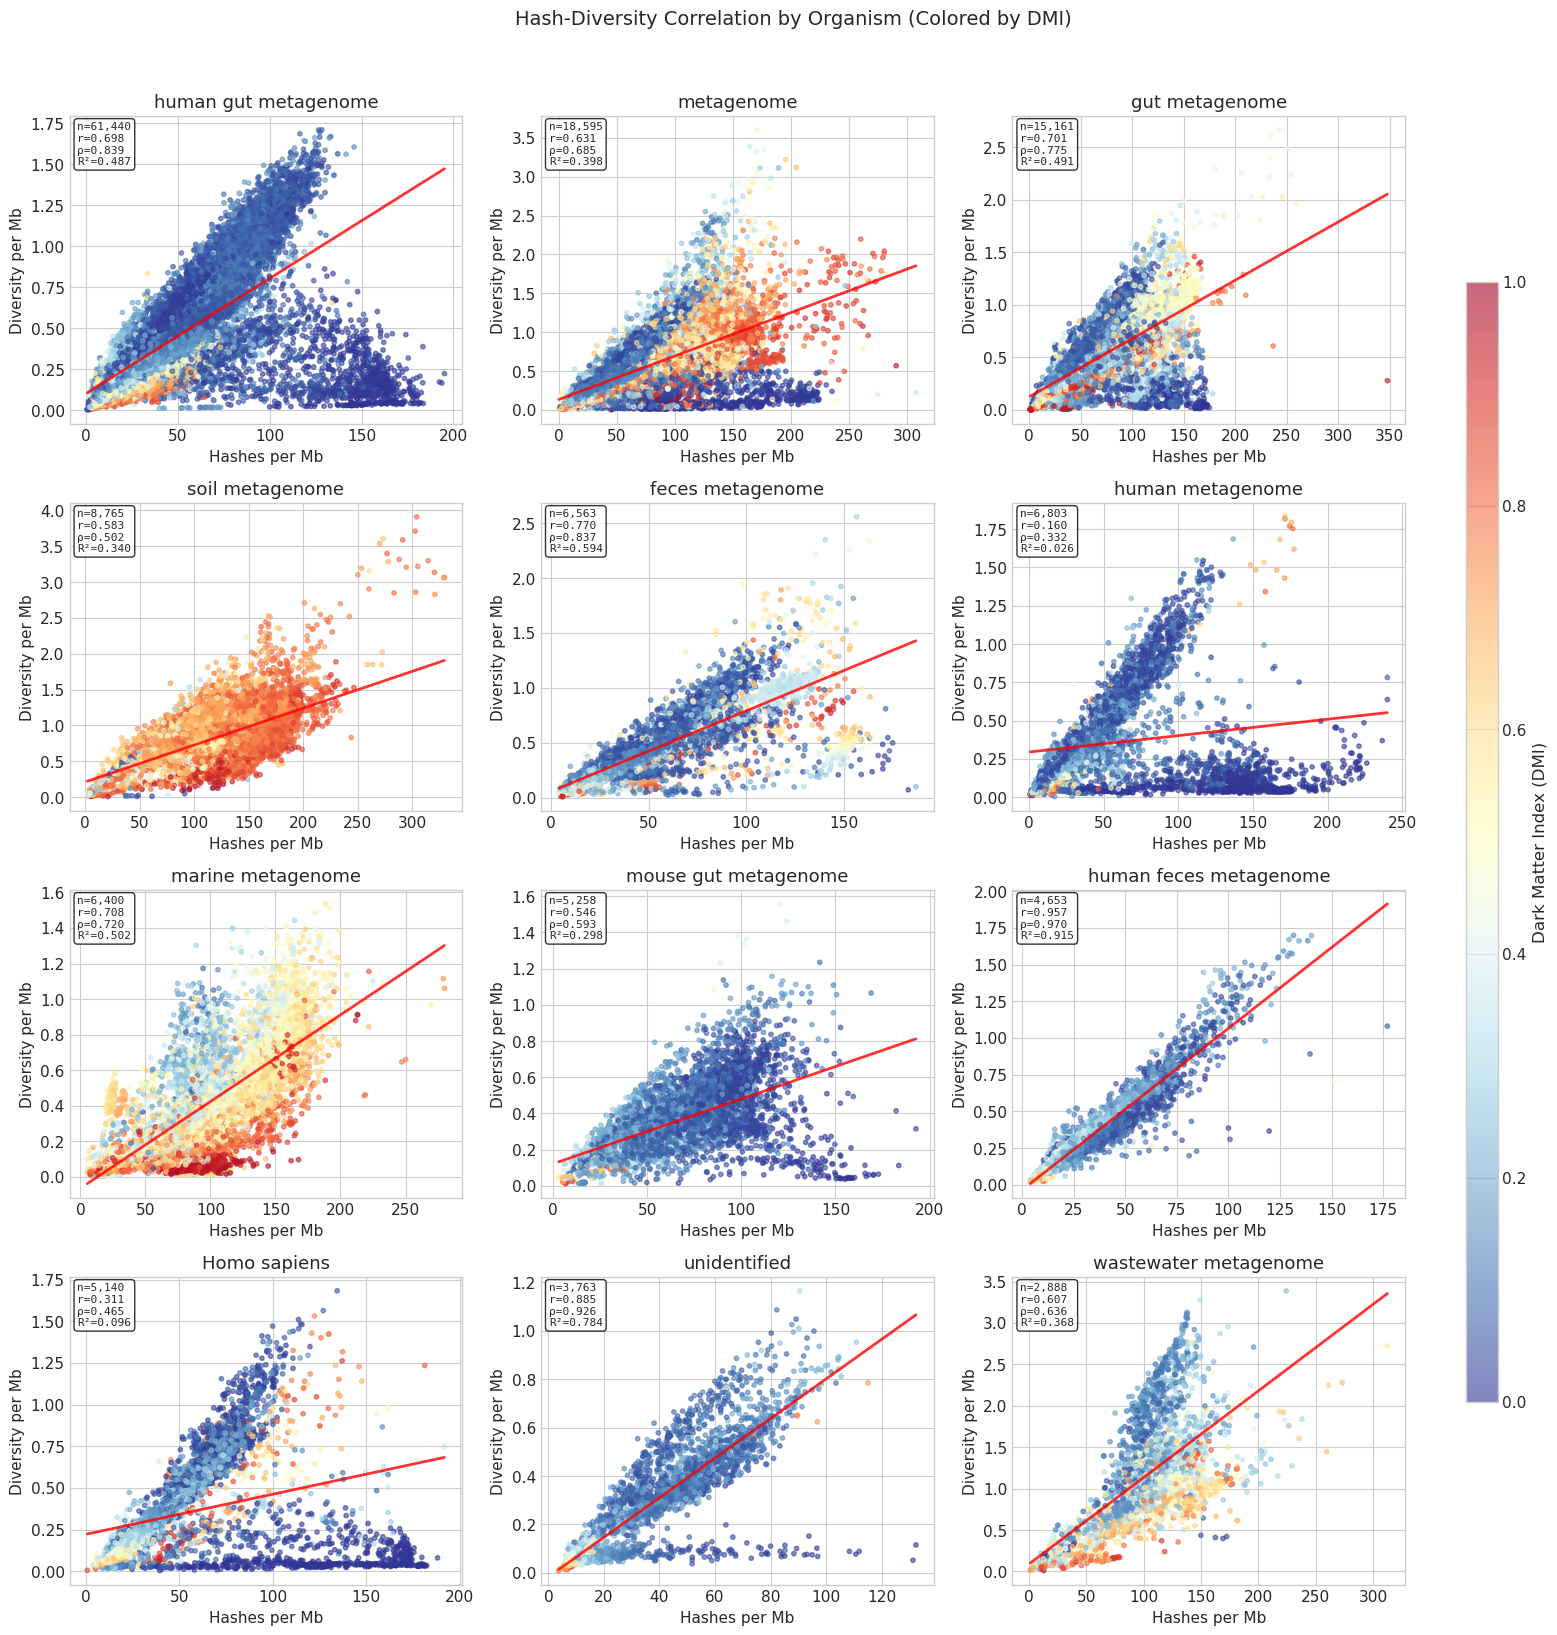


Figure saved: hash_diversity_by_organism_dmi_colored.png


In [60]:
# Select organisms for the multi-panel plot
# Using the same organisms from the original figure
target_organisms = [
    'human gut metagenome', 'metagenome', 'gut metagenome',
    'soil metagenome', 'feces metagenome', 'human metagenome',
    'marine metagenome', 'mouse gut metagenome', 'human feces metagenome',
    'Homo sapiens', 'unidentified', 'wastewater metagenome'
]

# Filter to organisms that exist in data
available_organisms = [org for org in target_organisms if org in df_dmi['organism'].values]
print(f"Plotting {len(available_organisms)} organisms")

# Create multi-panel figure
n_cols = 3
n_rows = (len(available_organisms) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

scatter = None
for idx, organism in enumerate(available_organisms):
    scatter = plot_organism_hash_diversity_dmi(df_dmi, organism, axes[idx])

# Hide unused axes
for idx in range(len(available_organisms), len(axes)):
    axes[idx].set_visible(False)

# Add colorbar
if scatter is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Dark Matter Index (DMI)', fontsize=12)

plt.suptitle('Hash-Diversity Correlation by Organism (Colored by DMI)', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('hash_diversity_by_organism_dmi_colored.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: hash_diversity_by_organism_dmi_colored.png")

### Interpretation Guide

**Color interpretation:**
- **Blue**: Low DMI (well-characterized samples, most hashes map to reference databases)
- **Yellow**: Medium DMI
- **Red**: High DMI (high dark matter content, many unmapped hashes)

**What to look for:**
1. Do the outlier clusters (bottom-right regions in some panels) appear red/yellow?
   - If yes: DMI explains the anomalous hash-diversity relationship
   - If no: Other factors drive the multimodality

2. Is there a gradient along the regression line?
   - Points above the line might have lower DMI (more characterized content)
   - Points below the line might have higher DMI (dark matter inflating hash counts)

## 5. Detailed Organism Analysis: Top and Bottom DMI

Deep dive into organisms with highest and lowest median DMI values.

In [61]:
# Calculate organism-level DMI statistics
organism_stats = df_dmi.groupby('organism').agg(
    count=('dmi', 'count'),
    median_dmi=('dmi', 'median'),
    mean_dmi=('dmi', 'mean'),
    std_dmi=('dmi', 'std'),
    q25_dmi=('dmi', lambda x: x.quantile(0.25)),
    q75_dmi=('dmi', lambda x: x.quantile(0.75)),
    median_hashes_per_mb=('hashes_per_mb', 'median'),
    median_diversity_per_mb=('diversity_per_mb', 'median'),
    median_alpha_diversity=('alpha_diversity', 'median')
).reset_index()

# Filter to organisms with at least 100 samples
organism_stats_filtered = organism_stats[organism_stats['count'] >= 100].copy()
print(f"Organisms with >= 100 samples: {len(organism_stats_filtered)}")

Organisms with >= 100 samples: 113


In [62]:
# Top 10 by median DMI
top10_dmi = organism_stats_filtered.nlargest(10, 'median_dmi')

print("\n" + "=" * 100)
print("TOP 10 ORGANISMS BY MEDIAN DMI (n >= 100)")
print("=" * 100)
print("\nThese organisms have the highest proportion of 'dark matter' — unmapped k-mer content.")
print("High DMI may indicate: (1) underrepresented in reference databases, (2) novel diversity,")
print("(3) environmental niches not well-characterized, or (4) technical artifacts.\n")

for i, row in top10_dmi.iterrows():
    print(f"\n{row['organism']}")
    print(f"  Sample count: {int(row['count']):,}")
    print(f"  DMI: median={row['median_dmi']:.4f}, mean={row['mean_dmi']:.4f}, std={row['std_dmi']:.4f}")
    print(f"  IQR: [{row['q25_dmi']:.4f}, {row['q75_dmi']:.4f}]")
    print(f"  Hashes/Mb: {row['median_hashes_per_mb']:.2f}")
    print(f"  Diversity/Mb: {row['median_diversity_per_mb']:.4f}")
    print(f"  Alpha diversity: {row['median_alpha_diversity']:.0f}")


TOP 10 ORGANISMS BY MEDIAN DMI (n >= 100)

These organisms have the highest proportion of 'dark matter' — unmapped k-mer content.
High DMI may indicate: (1) underrepresented in reference databases, (2) novel diversity,
(3) environmental niches not well-characterized, or (4) technical artifacts.


termite gut metagenome
  Sample count: 123
  DMI: median=0.9164, mean=0.8747, std=0.1129
  IQR: [0.8675, 0.9393]
  Hashes/Mb: 83.70
  Diversity/Mb: 0.1685
  Alpha diversity: 2412

museum specimen metagenome
  Sample count: 147
  DMI: median=0.8186, mean=0.7950, std=0.1031
  IQR: [0.7320, 0.8786]
  Hashes/Mb: 71.15
  Diversity/Mb: 0.4780
  Alpha diversity: 6124

wetland metagenome
  Sample count: 272
  DMI: median=0.8124, mean=0.7460, std=0.1619
  IQR: [0.6454, 0.8676]
  Hashes/Mb: 124.29
  Diversity/Mb: 0.5260
  Alpha diversity: 8780

pond metagenome
  Sample count: 110
  DMI: median=0.7807, mean=0.7054, std=0.1887
  IQR: [0.6103, 0.8478]
  Hashes/Mb: 122.62
  Diversity/Mb: 0.5506
  Alpha div

In [63]:
# Bottom 10 by median DMI
bottom10_dmi = organism_stats_filtered.nsmallest(10, 'median_dmi')

print("\n" + "=" * 100)
print("BOTTOM 10 ORGANISMS BY MEDIAN DMI (n >= 100)")
print("=" * 100)
print("\nThese organisms have the lowest proportion of 'dark matter' — most k-mers map to references.")
print("Low DMI indicates: (1) well-characterized organisms, (2) extensively sequenced,")
print("(3) lab strains or model organisms, or (4) limited natural diversity.\n")

for i, row in bottom10_dmi.iterrows():
    print(f"\n{row['organism']}")
    print(f"  Sample count: {int(row['count']):,}")
    print(f"  DMI: median={row['median_dmi']:.4f}, mean={row['mean_dmi']:.4f}, std={row['std_dmi']:.4f}")
    print(f"  IQR: [{row['q25_dmi']:.4f}, {row['q75_dmi']:.4f}]")
    print(f"  Hashes/Mb: {row['median_hashes_per_mb']:.2f}")
    print(f"  Diversity/Mb: {row['median_diversity_per_mb']:.4f}")
    print(f"  Alpha diversity: {row['median_alpha_diversity']:.0f}")


BOTTOM 10 ORGANISMS BY MEDIAN DMI (n >= 100)

These organisms have the lowest proportion of 'dark matter' — most k-mers map to references.
Low DMI indicates: (1) well-characterized organisms, (2) extensively sequenced,
(3) lab strains or model organisms, or (4) limited natural diversity.


eye metagenome
  Sample count: 444
  DMI: median=0.0062, mean=0.0152, std=0.0394
  IQR: [0.0024, 0.0142]
  Hashes/Mb: 168.16
  Diversity/Mb: 0.0701
  Alpha diversity: 391

metagenomes
  Sample count: 128
  DMI: median=0.0128, mean=0.0931, std=0.2194
  IQR: [0.0098, 0.0224]
  Hashes/Mb: 171.51
  Diversity/Mb: 0.2035
  Alpha diversity: 680

Oryza sativa Japonica Group
  Sample count: 142
  DMI: median=0.0155, mean=0.0164, std=0.0055
  IQR: [0.0130, 0.0184]
  Hashes/Mb: 96.98
  Diversity/Mb: 0.0848
  Alpha diversity: 240

human sputum metagenome
  Sample count: 194
  DMI: median=0.0189, mean=0.1140, std=0.1639
  IQR: [0.0040, 0.1849]
  Hashes/Mb: 142.27
  Diversity/Mb: 0.0692
  Alpha diversity: 507

pl

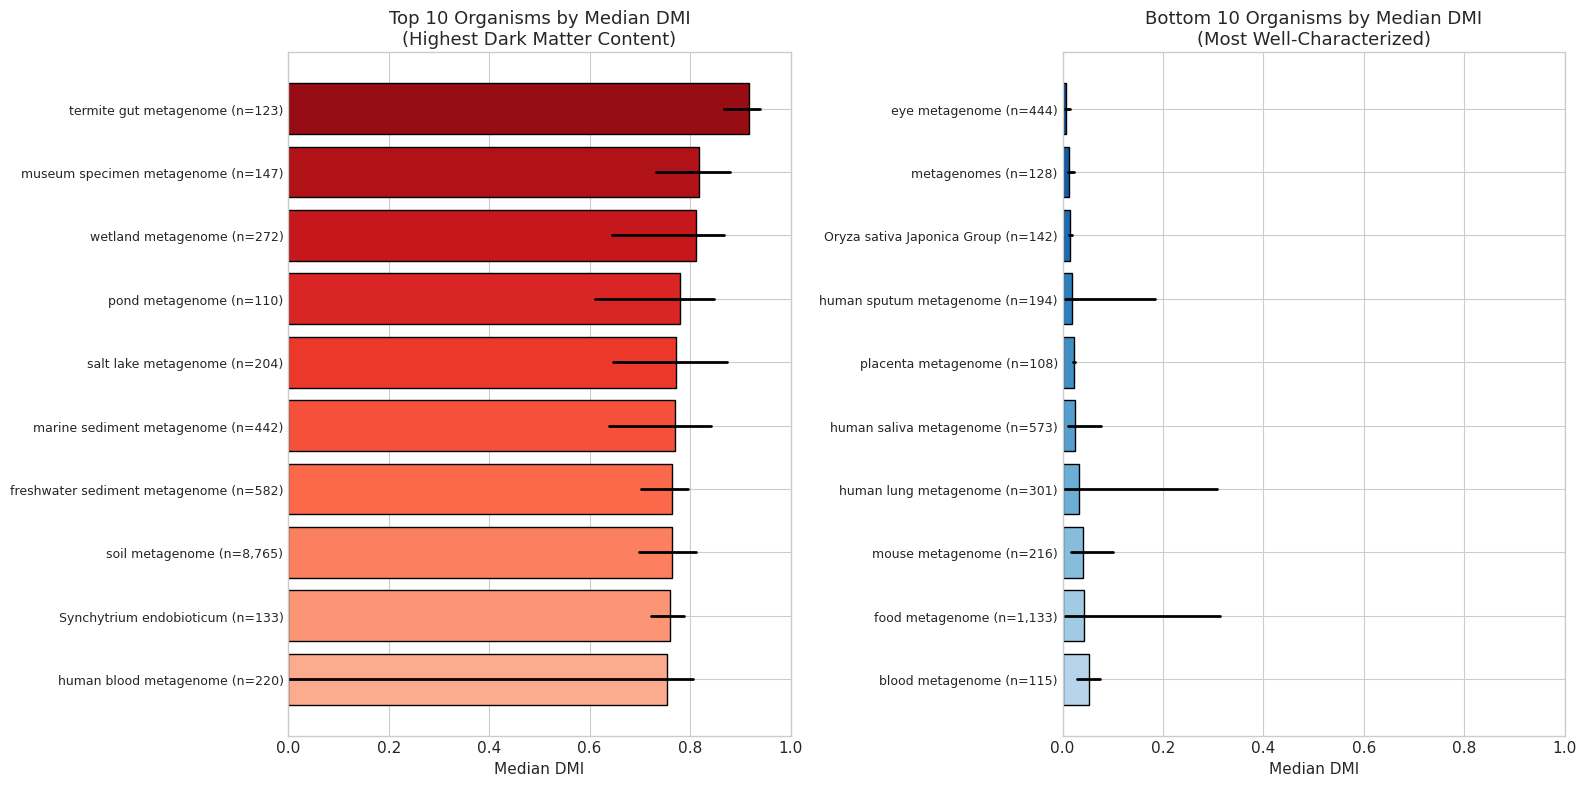


Figure saved: top_bottom_organisms_dmi.png


In [64]:
# Visualization: Top and Bottom organisms
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10
ax = axes[0]
top10_sorted = top10_dmi.sort_values('median_dmi', ascending=True)
colors_top = plt.cm.Reds(np.linspace(0.3, 0.9, len(top10_sorted)))
bars = ax.barh(range(len(top10_sorted)), top10_sorted['median_dmi'], 
               color=colors_top, edgecolor='black')

# Add error bars for IQR
for idx, (_, row) in enumerate(top10_sorted.iterrows()):
    ax.plot([row['q25_dmi'], row['q75_dmi']], [idx, idx], 'k-', linewidth=2)
    
ax.set_yticks(range(len(top10_sorted)))
ax.set_yticklabels([f"{row['organism']} (n={int(row['count']):,})" 
                    for _, row in top10_sorted.iterrows()], fontsize=9)
ax.set_xlabel('Median DMI')
ax.set_title('Top 10 Organisms by Median DMI\n(Highest Dark Matter Content)')
ax.set_xlim(0, 1)

# Bottom 10
ax = axes[1]
bottom10_sorted = bottom10_dmi.sort_values('median_dmi', ascending=False)
colors_bottom = plt.cm.Blues(np.linspace(0.3, 0.9, len(bottom10_sorted)))
bars = ax.barh(range(len(bottom10_sorted)), bottom10_sorted['median_dmi'],
               color=colors_bottom, edgecolor='black')

# Add error bars for IQR
for idx, (_, row) in enumerate(bottom10_sorted.iterrows()):
    ax.plot([row['q25_dmi'], row['q75_dmi']], [idx, idx], 'k-', linewidth=2)

ax.set_yticks(range(len(bottom10_sorted)))
ax.set_yticklabels([f"{row['organism']} (n={int(row['count']):,})" 
                    for _, row in bottom10_sorted.iterrows()], fontsize=9)
ax.set_xlabel('Median DMI')
ax.set_title('Bottom 10 Organisms by Median DMI\n(Most Well-Characterized)')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('top_bottom_organisms_dmi.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: top_bottom_organisms_dmi.png")

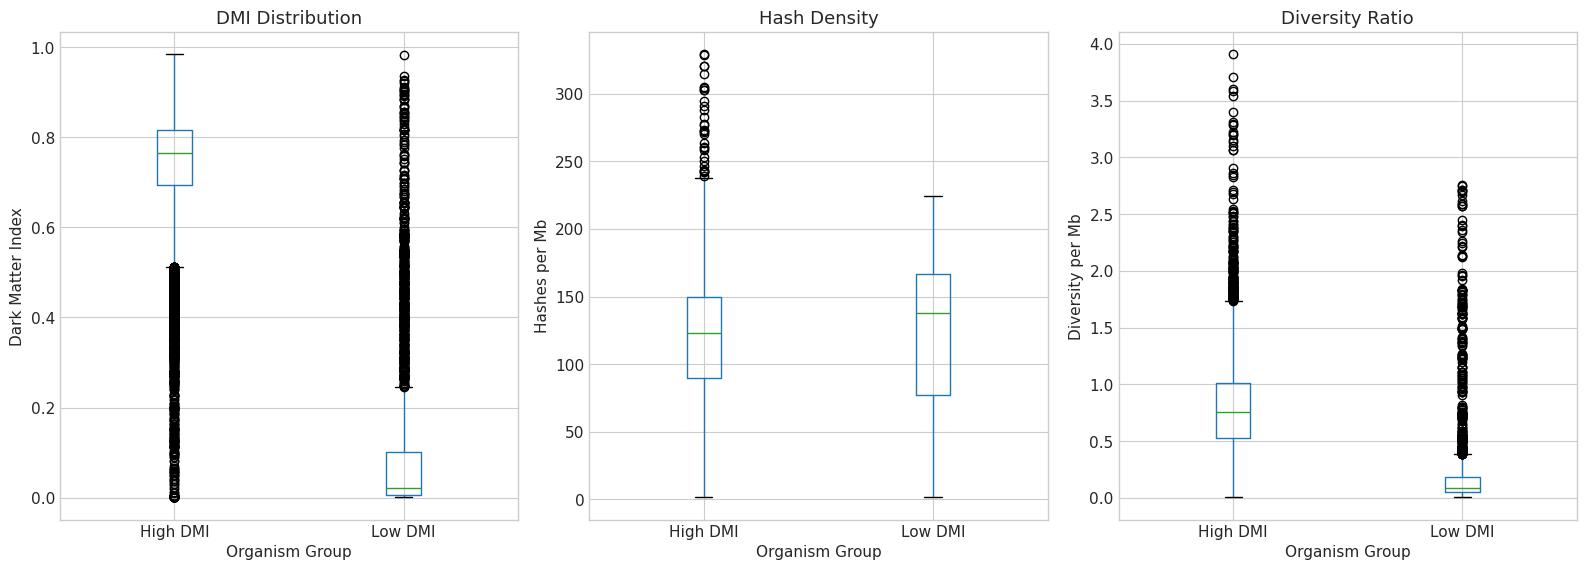

Figure saved: high_low_dmi_comparison.png


In [65]:
# Boxplot comparison: Top 10 vs Bottom 10 organisms
top10_names = top10_dmi['organism'].tolist()
bottom10_names = bottom10_dmi['organism'].tolist()

df_comparison = df_dmi[df_dmi['organism'].isin(top10_names + bottom10_names)].copy()
df_comparison['group'] = df_comparison['organism'].apply(
    lambda x: 'High DMI' if x in top10_names else 'Low DMI'
)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# DMI distribution
ax = axes[0]
df_comparison.boxplot(column='dmi', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Dark Matter Index')
ax.set_title('DMI Distribution')
plt.suptitle('')

# Hashes per Mb
ax = axes[1]
df_comparison.boxplot(column='hashes_per_mb', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Hashes per Mb')
ax.set_title('Hash Density')
plt.suptitle('')

# Diversity per Mb
ax = axes[2]
df_comparison.boxplot(column='diversity_per_mb', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Diversity Ratio')
plt.suptitle('')

plt.tight_layout()
plt.savefig('high_low_dmi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: high_low_dmi_comparison.png")

## 6. Outlier Investigation: Testing the Hypothesis Directly

Identifying samples that deviate from the expected hash-diversity relationship and testing if they have elevated DMI.

In [66]:
def identify_outliers(df, x_col, y_col, residual_threshold=2):
    """
    Identify outliers based on residuals from linear regression.
    
    Outliers are defined as points whose residual (observed - predicted)
    is more than `residual_threshold` standard deviations below the mean.
    
    These are samples with lower diversity than expected given their hash density.
    """
    # Clean data
    mask = df[x_col].notna() & df[y_col].notna()
    df_clean = df[mask].copy()
    
    x = df_clean[x_col].values
    y = df_clean[y_col].values
    
    # Fit linear regression
    slope, intercept, _, _, _ = stats.linregress(x, y)
    
    # Calculate residuals
    y_pred = slope * x + intercept
    residuals = y - y_pred
    
    # Standardize residuals
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    standardized_residuals = (residuals - residual_mean) / residual_std
    
    # Identify negative outliers (below regression line)
    df_clean['residual'] = residuals
    df_clean['std_residual'] = standardized_residuals
    df_clean['is_outlier'] = standardized_residuals < -residual_threshold
    
    return df_clean

In [67]:
# Identify outliers for each major organism
print("Outlier Analysis: Samples with LOW diversity relative to hash density")
print("="*80)
print("\nHypothesis: Outliers (below regression line) should have HIGHER DMI")
print("")

outlier_results = []

for organism in available_organisms:
    subset = df_dmi[df_dmi['organism'] == organism]
    if len(subset) < 100:
        continue
    
    df_with_outliers = identify_outliers(subset, 'hashes_per_mb', 'diversity_per_mb', residual_threshold=2)
    
    n_outliers = df_with_outliers['is_outlier'].sum()
    n_total = len(df_with_outliers)
    
    dmi_outliers = df_with_outliers[df_with_outliers['is_outlier']]['dmi']
    dmi_normal = df_with_outliers[~df_with_outliers['is_outlier']]['dmi']
    
    # Statistical test
    if len(dmi_outliers) > 5 and len(dmi_normal) > 5:
        stat, pvalue = stats.mannwhitneyu(dmi_outliers, dmi_normal, alternative='greater')
        
        result = {
            'organism': organism,
            'n_total': n_total,
            'n_outliers': n_outliers,
            'pct_outliers': 100 * n_outliers / n_total,
            'dmi_outliers_median': dmi_outliers.median(),
            'dmi_normal_median': dmi_normal.median(),
            'dmi_difference': dmi_outliers.median() - dmi_normal.median(),
            'mannwhitney_pvalue': pvalue,
            'significant': pvalue < 0.05
        }
        outlier_results.append(result)

outlier_df = pd.DataFrame(outlier_results)
outlier_df = outlier_df.sort_values('dmi_difference', ascending=False)

Outlier Analysis: Samples with LOW diversity relative to hash density

Hypothesis: Outliers (below regression line) should have HIGHER DMI



In [68]:
# Display outlier analysis results
print("\nResults: Do outliers have higher DMI than normal samples?")
print("-" * 100)
print(f"{'Organism':<30} {'n_out':>6} {'%out':>6} {'DMI_out':>8} {'DMI_norm':>8} {'Δ DMI':>8} {'p-value':>10} {'Sig?':>5}")
print("-" * 100)

for _, row in outlier_df.iterrows():
    sig_marker = '***' if row['mannwhitney_pvalue'] < 0.001 else ('**' if row['mannwhitney_pvalue'] < 0.01 else ('*' if row['mannwhitney_pvalue'] < 0.05 else ''))
    print(f"{row['organism']:<30} {row['n_outliers']:>6} {row['pct_outliers']:>5.1f}% {row['dmi_outliers_median']:>8.4f} {row['dmi_normal_median']:>8.4f} {row['dmi_difference']:>+8.4f} {row['mannwhitney_pvalue']:>10.2e} {sig_marker:>5}")


Results: Do outliers have higher DMI than normal samples?
----------------------------------------------------------------------------------------------------
Organism                        n_out   %out  DMI_out DMI_norm    Δ DMI    p-value  Sig?
----------------------------------------------------------------------------------------------------
marine metagenome                  43   0.7%   0.8932   0.5343  +0.3589   8.80e-19   ***
feces metagenome                  215   3.3%   0.3210   0.1131  +0.2079   6.08e-12   ***
soil metagenome                    39   0.4%   0.8376   0.7627  +0.0750   1.23e-06   ***
wastewater metagenome              19   0.7%   0.3013   0.3123  -0.0110   2.95e-01      
mouse gut metagenome              143   2.7%   0.0133   0.0670  -0.0537   1.00e+00      
human gut metagenome             1364   2.2%   0.0112   0.0745  -0.0634   1.00e+00      
gut metagenome                    572   3.8%   0.0370   0.1040  -0.0669   1.00e+00      
Homo sapiens               

In [69]:
# Summary statistics
n_significant = outlier_df['significant'].sum()
n_positive_diff = (outlier_df['dmi_difference'] > 0).sum()

print(f"\n\nSUMMARY:")
print(f"  Organisms analyzed: {len(outlier_df)}")
print(f"  Organisms where outliers have HIGHER DMI: {n_positive_diff} ({100*n_positive_diff/len(outlier_df):.1f}%)")
print(f"  Statistically significant (p < 0.05): {n_significant} ({100*n_significant/len(outlier_df):.1f}%)")

if n_positive_diff / len(outlier_df) > 0.5:
    print("\n  → SUPPORTS HYPOTHESIS: Outliers tend to have higher DMI")
else:
    print("\n  → DOES NOT SUPPORT HYPOTHESIS: Outliers don't consistently have higher DMI")



SUMMARY:
  Organisms analyzed: 11
  Organisms where outliers have HIGHER DMI: 3 (27.3%)
  Statistically significant (p < 0.05): 3 (27.3%)

  → DOES NOT SUPPORT HYPOTHESIS: Outliers don't consistently have higher DMI


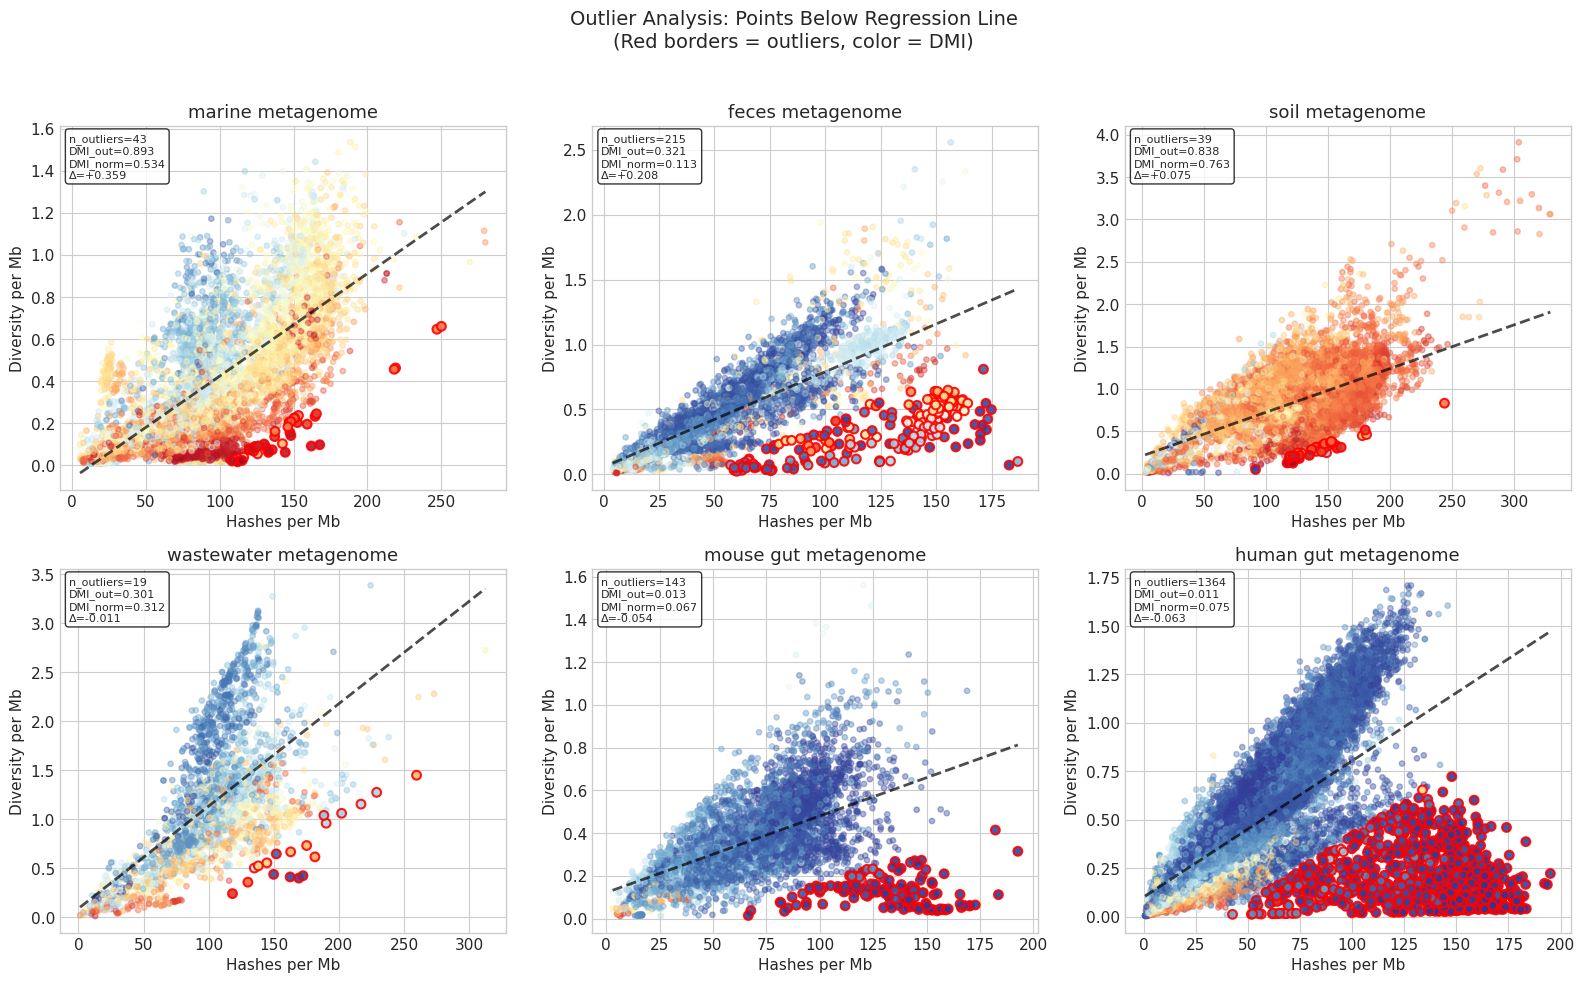


Figure saved: outlier_dmi_analysis.png


In [70]:
# Visualize outliers vs normal for selected organisms
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Select organisms with significant differences
top_organisms = outlier_df.nlargest(6, 'dmi_difference')['organism'].tolist()

for idx, organism in enumerate(top_organisms):
    if idx >= 6:
        break
        
    ax = axes[idx]
    subset = df_dmi[df_dmi['organism'] == organism]
    df_with_outliers = identify_outliers(subset, 'hashes_per_mb', 'diversity_per_mb', residual_threshold=2)
    
    # Plot normal points
    normal = df_with_outliers[~df_with_outliers['is_outlier']]
    outliers = df_with_outliers[df_with_outliers['is_outlier']]
    
    ax.scatter(normal['hashes_per_mb'], normal['diversity_per_mb'], 
               c=normal['dmi'], cmap='RdYlBu_r', alpha=0.4, s=15, vmin=0, vmax=1, label='Normal')
    ax.scatter(outliers['hashes_per_mb'], outliers['diversity_per_mb'],
               c=outliers['dmi'], cmap='RdYlBu_r', alpha=0.9, s=40, vmin=0, vmax=1, 
               edgecolor='red', linewidth=1.5, label='Outliers')
    
    # Add regression line
    x = df_with_outliers['hashes_per_mb'].values
    y = df_with_outliers['diversity_per_mb'].values
    slope, intercept, _, _, _ = stats.linregress(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 'k--', linewidth=2, alpha=0.7)
    
    # Stats
    row = outlier_df[outlier_df['organism'] == organism].iloc[0]
    ax.text(0.02, 0.98, 
            f"n_outliers={row['n_outliers']}\nDMI_out={row['dmi_outliers_median']:.3f}\nDMI_norm={row['dmi_normal_median']:.3f}\nΔ={row['dmi_difference']:+.3f}",
            transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    ax.set_title(organism)

plt.suptitle('Outlier Analysis: Points Below Regression Line\n(Red borders = outliers, color = DMI)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('outlier_dmi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: outlier_dmi_analysis.png")

## 7. Additional Analyses

### 7.1 DMI by Platform and Sequencing Technology

Check if DMI varies by sequencing platform (potential technical artifact).

DMI by Sequencing Platform:
ILLUMINA             n= 192,893  median=0.1744  mean=0.2830
BGISEQ               n=   3,000  median=0.0851  mean=0.1687
ION_TORRENT          n=   1,752  median=0.1257  mean=0.1808
DNBSEQ               n=   1,478  median=0.0964  mean=0.1913
OXFORD_NANOPORE      n=   1,112  median=0.6037  mean=0.5948
ABI_SOLID            n=     562  median=0.2796  mean=0.2996
PACBIO_SMRT          n=     180  median=0.5794  mean=0.5692
COMPLETE_GENOMICS    n=      81  median=0.2922  mean=0.4560
LS454                n=       1  median=0.8473  mean=0.8473


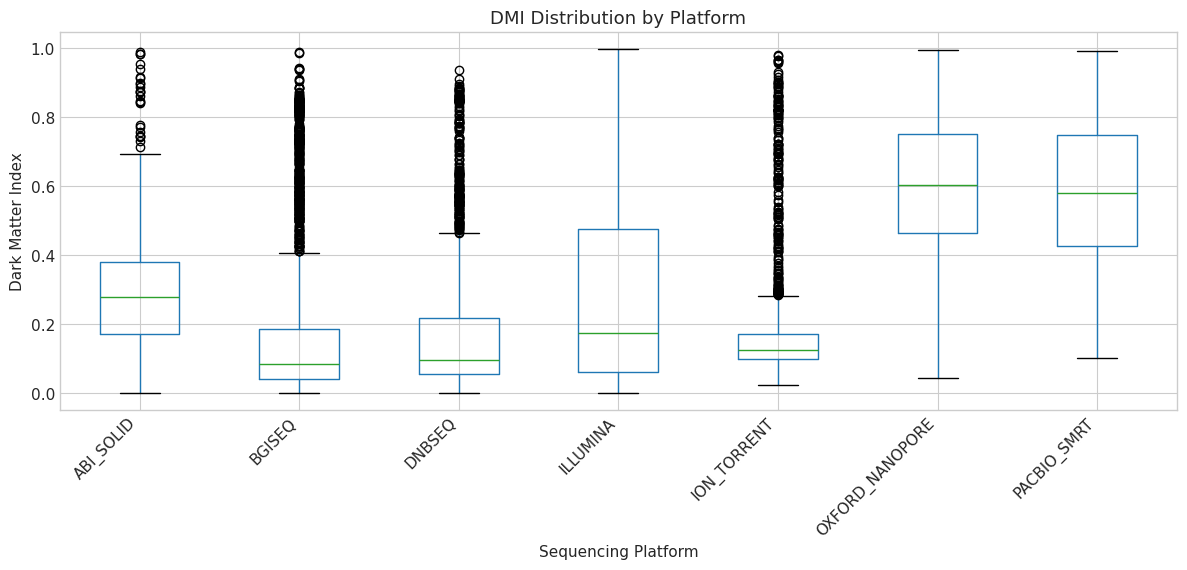


Figure saved: dmi_by_platform.png


In [71]:
if 'platform' in df_dmi.columns:
    platform_stats = df_dmi.groupby('platform').agg(
        count=('dmi', 'count'),
        median_dmi=('dmi', 'median'),
        mean_dmi=('dmi', 'mean'),
        std_dmi=('dmi', 'std')
    ).reset_index()
    platform_stats = platform_stats.sort_values('count', ascending=False)
    
    print("DMI by Sequencing Platform:")
    print("=" * 70)
    for _, row in platform_stats.iterrows():
        print(f"{row['platform']:20} n={int(row['count']):>8,}  median={row['median_dmi']:.4f}  mean={row['mean_dmi']:.4f}")
    
    # Box plot
    fig, ax = plt.subplots(figsize=(12, 6))
    platforms_to_plot = platform_stats[platform_stats['count'] >= 100]['platform'].tolist()
    df_platform = df_dmi[df_dmi['platform'].isin(platforms_to_plot)]
    df_platform.boxplot(column='dmi', by='platform', ax=ax)
    ax.set_xlabel('Sequencing Platform')
    ax.set_ylabel('Dark Matter Index')
    ax.set_title('DMI Distribution by Platform')
    plt.suptitle('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('dmi_by_platform.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nFigure saved: dmi_by_platform.png")
else:
    print("Platform column not available in dataset")

### 7.2 DMI by Biome

Environmental context and dark matter content.

DMI by Biome (n >= 100):
WWF_TEW_BIOME_11                         n=   766  median=0.6725  mean=0.6524
WWF_TEW_BIOME_99                         n=   280  median=0.6334  mean=0.5598
WWF_TEW_BIOME_14                         n=   211  median=0.5787  mean=0.5743
WWF_TEW_BIOME_02                         n=   533  median=0.3233  mean=0.3711
WWF_TEW_BIOME_06                         n= 7,117  median=0.2975  mean=0.3395
WWF_TEW_BIOME_13                         n= 6,079  median=0.2726  mean=0.3467
unknown                                  n=20,165  median=0.2655  mean=0.3345
WWF_TEW_BIOME_05                         n=12,521  median=0.2463  mean=0.3259
WWF_TEW_BIOME_10                         n=17,092  median=0.2304  mean=0.3434
WWF_TEW_BIOME_08                         n= 5,438  median=0.2027  mean=0.2999
WWF_TEW_BIOME_07                         n= 4,948  median=0.1790  mean=0.2756
WWF_TEW_BIOME_01                         n=13,346  median=0.1784  mean=0.3075
WWF_TEW_BIOME_12                       

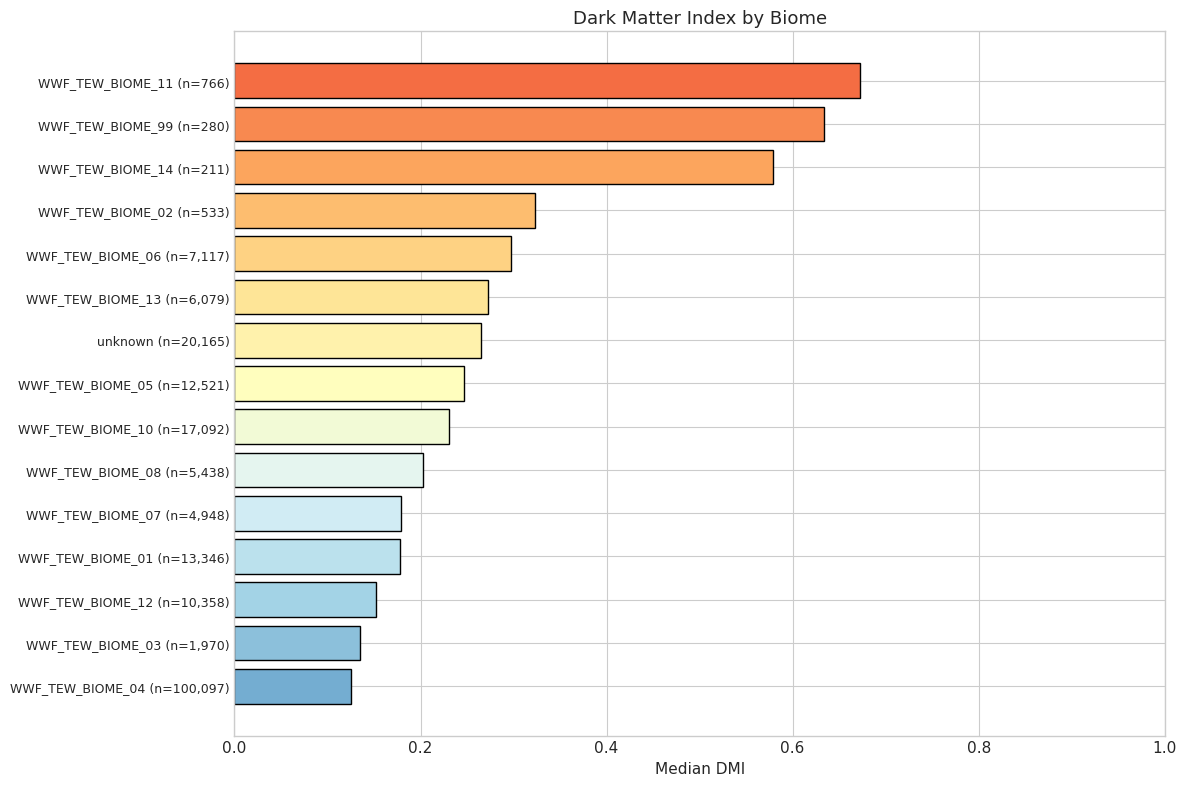


Figure saved: dmi_by_biome.png


In [72]:
if 'biome' in df_dmi.columns:
    biome_stats = df_dmi.groupby('biome').agg(
        count=('dmi', 'count'),
        median_dmi=('dmi', 'median'),
        mean_dmi=('dmi', 'mean'),
        std_dmi=('dmi', 'std')
    ).reset_index()
    
    biome_stats_filtered = biome_stats[biome_stats['count'] >= 100]
    biome_stats_filtered = biome_stats_filtered.sort_values('median_dmi', ascending=False)
    
    print("DMI by Biome (n >= 100):")
    print("=" * 80)
    for _, row in biome_stats_filtered.iterrows():
        print(f"{row['biome']:40} n={int(row['count']):>6,}  median={row['median_dmi']:.4f}  mean={row['mean_dmi']:.4f}")
    
    # Visualization
    if len(biome_stats_filtered) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        biome_stats_filtered = biome_stats_filtered.sort_values('median_dmi', ascending=True)
        colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(biome_stats_filtered)))
        ax.barh(range(len(biome_stats_filtered)), biome_stats_filtered['median_dmi'],
                color=colors, edgecolor='black')
        ax.set_yticks(range(len(biome_stats_filtered)))
        ax.set_yticklabels([f"{row['biome']} (n={int(row['count']):,})" 
                           for _, row in biome_stats_filtered.iterrows()], fontsize=9)
        ax.set_xlabel('Median DMI')
        ax.set_title('Dark Matter Index by Biome')
        ax.set_xlim(0, 1)
        plt.tight_layout()
        plt.savefig('dmi_by_biome.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\nFigure saved: dmi_by_biome.png")
else:
    print("Biome column not available in dataset")

### 7.3 Relationship Between Mapped Hashes and Alpha Diversity

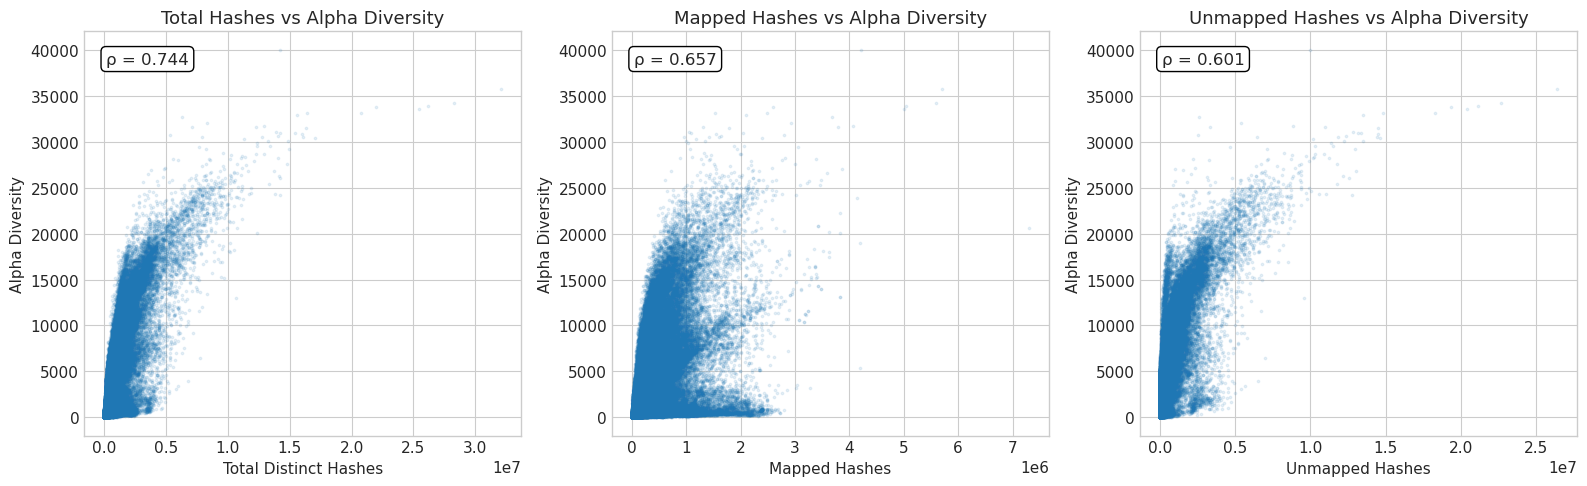

Figure saved: hash_types_vs_alpha_diversity.png

Interpretation: If mapped hashes correlate BETTER with alpha diversity than total hashes,
this supports the idea that unmapped hashes (dark matter) dilute the diversity signal.


In [73]:
# Key insight: Does alpha diversity correlate better with MAPPED hashes than TOTAL hashes?
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Total hashes vs alpha diversity
ax = axes[0]
ax.scatter(df_dmi['total_distinct_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['total_distinct_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Total Distinct Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Total Hashes vs Alpha Diversity')

# Mapped hashes vs alpha diversity
ax = axes[1]
ax.scatter(df_dmi['mapped_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['mapped_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Mapped Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Mapped Hashes vs Alpha Diversity')

# Unmapped hashes vs alpha diversity
ax = axes[2]
ax.scatter(df_dmi['unmapped_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['unmapped_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Unmapped Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Unmapped Hashes vs Alpha Diversity')

plt.tight_layout()
plt.savefig('hash_types_vs_alpha_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: hash_types_vs_alpha_diversity.png")
print("\nInterpretation: If mapped hashes correlate BETTER with alpha diversity than total hashes,")
print("this supports the idea that unmapped hashes (dark matter) dilute the diversity signal.")

### 7.4 Quantifying Dark Matter's Contribution to Variance

In [74]:
# Can we explain more variance in diversity_per_mb by including DMI in a model?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data (drop NaN)
model_df = df_dmi[['hashes_per_mb', 'diversity_per_mb', 'dmi']].dropna()

X_simple = model_df[['hashes_per_mb']].values
X_with_dmi = model_df[['hashes_per_mb', 'dmi']].values
y = model_df['diversity_per_mb'].values

# Model 1: diversity_per_mb ~ hashes_per_mb
model_simple = LinearRegression()
model_simple.fit(X_simple, y)
y_pred_simple = model_simple.predict(X_simple)
r2_simple = r2_score(y, y_pred_simple)

# Model 2: diversity_per_mb ~ hashes_per_mb + dmi
model_dmi = LinearRegression()
model_dmi.fit(X_with_dmi, y)
y_pred_dmi = model_dmi.predict(X_with_dmi)
r2_dmi = r2_score(y, y_pred_dmi)

print("Linear Model Comparison:")
print("=" * 60)
print(f"\nModel 1: diversity_per_mb ~ hashes_per_mb")
print(f"  R² = {r2_simple:.4f}")
print(f"  Coefficient: {model_simple.coef_[0]:.6f}")

print(f"\nModel 2: diversity_per_mb ~ hashes_per_mb + dmi")
print(f"  R² = {r2_dmi:.4f}")
print(f"  Coefficients: hashes_per_mb={model_dmi.coef_[0]:.6f}, dmi={model_dmi.coef_[1]:.6f}")

print(f"\n  ΔR² = {r2_dmi - r2_simple:.4f}")
print(f"  Adding DMI explains {100*(r2_dmi - r2_simple):.2f}% additional variance")

if model_dmi.coef_[1] < 0:
    print(f"\n  → DMI coefficient is NEGATIVE, meaning higher DMI → lower diversity_per_mb")
    print(f"    This SUPPORTS the hypothesis that dark matter dilutes diversity signal.")
else:
    print(f"\n  → DMI coefficient is POSITIVE, unexpected result.")

Linear Model Comparison:

Model 1: diversity_per_mb ~ hashes_per_mb
  R² = 0.3545
  Coefficient: 0.005235

Model 2: diversity_per_mb ~ hashes_per_mb + dmi
  R² = 0.3556
  Coefficients: hashes_per_mb=0.005305, dmi=-0.049926

  ΔR² = 0.0011
  Adding DMI explains 0.11% additional variance

  → DMI coefficient is NEGATIVE, meaning higher DMI → lower diversity_per_mb
    This SUPPORTS the hypothesis that dark matter dilutes diversity signal.


## 8. Summary and Conclusions

In [75]:
print("="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. DATASET OVERVIEW")
print(f"   - Total samples analyzed: {len(df_dmi):,}")
print(f"   - Organisms represented: {df_dmi['organism'].nunique():,}")

print(f"\n2. DMI DISTRIBUTION")
print(f"   - Mean DMI: {df_dmi['dmi'].mean():.4f}")
print(f"   - Median DMI: {df_dmi['dmi'].median():.4f}")
print(f"   - Samples with DMI > 0.5: {(df_dmi['dmi'] > 0.5).sum():,} ({100*(df_dmi['dmi'] > 0.5).mean():.1f}%)")

print(f"\n3. KEY CORRELATIONS")
r_hash, _ = spearmanr(df_dmi['dmi'], df_dmi['hashes_per_mb'])
r_div, _ = spearmanr(df_dmi['dmi'], df_dmi['diversity_per_mb'])
print(f"   - DMI vs Hashes/Mb: ρ = {r_hash:.4f}")
print(f"   - DMI vs Diversity/Mb: ρ = {r_div:.4f}")

print(f"\n4. TOP DARK MATTER ORGANISMS (median DMI, n>=100):")
for i, (_, row) in enumerate(top10_dmi.head(5).iterrows()):
    print(f"   {i+1}. {row['organism']}: {row['median_dmi']:.4f}")

print(f"\n5. OUTLIER ANALYSIS")
n_sig = outlier_df['significant'].sum() if 'outlier_df' in dir() else 0
print(f"   - Organisms where outliers have significantly higher DMI: {n_sig}/{len(outlier_df)}")

print(f"\n6. MODEL COMPARISON")
print(f"   - R² without DMI: {r2_simple:.4f}")
print(f"   - R² with DMI: {r2_dmi:.4f}")
print(f"   - Variance explained by DMI: {100*(r2_dmi - r2_simple):.2f}%")

print("\n" + "="*80)
print("HYPOTHESIS EVALUATION")
print("="*80)
print("""
The hypothesis that Dark Matter Index explains the multi-modal distribution
of alpha diversity vs hash density can be evaluated by examining:

1. Do outliers (samples below the regression line) have higher DMI?
2. Does including DMI in a predictive model improve variance explained?
3. Do high-DMI organisms show the expected pattern?

Review the figures and statistics above to draw conclusions.
""")

ANALYSIS SUMMARY

1. DATASET OVERVIEW
   - Total samples analyzed: 201,059
   - Organisms represented: 1,166

2. DMI DISTRIBUTION
   - Mean DMI: 0.2819
   - Median DMI: 0.1718
   - Samples with DMI > 0.5: 46,637 (23.2%)

3. KEY CORRELATIONS
   - DMI vs Hashes/Mb: ρ = 0.0485
   - DMI vs Diversity/Mb: ρ = 0.0026

4. TOP DARK MATTER ORGANISMS (median DMI, n>=100):
   1. termite gut metagenome: 0.9164
   2. museum specimen metagenome: 0.8186
   3. wetland metagenome: 0.8124
   4. pond metagenome: 0.7807
   5. salt lake metagenome: 0.7724

5. OUTLIER ANALYSIS
   - Organisms where outliers have significantly higher DMI: 3/11

6. MODEL COMPARISON
   - R² without DMI: 0.3545
   - R² with DMI: 0.3556
   - Variance explained by DMI: 0.11%

HYPOTHESIS EVALUATION

The hypothesis that Dark Matter Index explains the multi-modal distribution
of alpha diversity vs hash density can be evaluated by examining:

1. Do outliers (samples below the regression line) have higher DMI?
2. Does including DMI in a

In [76]:
# List all generated figures
print("\nGenerated Figures:")
print("-" * 40)
import os
for f in sorted(os.listdir('.')):
    if f.endswith('.png'):
        print(f"  - {f}")


Generated Figures:
----------------------------------------
  - correlation_matrices.png
  - dmi_by_biome.png
  - dmi_by_platform.png
  - dmi_distribution_overview.png
  - dmi_vs_metrics_scatter.png
  - hash_diversity_by_organism_dmi_colored.png
  - hash_types_vs_alpha_diversity.png
  - high_low_dmi_comparison.png
  - outlier_dmi_analysis.png
  - top_bottom_organisms_dmi.png


---

## Appendix: Running This Notebook

### Interactive Mode (Browser via X11)

```bash
# On your local machine, connect with X11 forwarding
ssh -X user@server

# Start Jupyter
jupyter notebook --no-browser --port=8888

# Or use Jupyter Lab
jupyter lab --no-browser --port=8888

# Then open the URL in your local browser
```

### Headless Mode (Command Line Execution)

```bash
# Execute and save outputs
jupyter nbconvert --to notebook --execute dmi_analysis.ipynb --output dmi_analysis_executed.ipynb

# Or convert to HTML for easy viewing
jupyter nbconvert --to html --execute dmi_analysis.ipynb --output dmi_analysis_report.html

# Or run as Python script
jupyter nbconvert --to script dmi_analysis.ipynb
python dmi_analysis.py
```

### Notes

- For headless execution, uncomment `matplotlib.use('Agg')` in the first code cell
- All figures are saved as PNG files in the working directory
- Modify `PARQUET_PATH` in Section 1 to point to your data file